1. Архитектура:

RNN: Простая рекуррентная нейронная сеть имеет проблему "затухания градиента", которая делает ее менее эффективной при обработке длинных последовательностей.

LSTM: LSTM была разработана для решения проблемы затухания градиента. Она имеет специальную структуру с тремя вентилями (входной, забывания и выходной), что позволяет ей лучше сохранять и управлять долгосрочной зависимостью в данных.

GRU: GRU - это более легковесная версия LSTM с двумя вентилями (входным и обновляющим), что делает ее более простой в реализации и обучении.

2. Количество параметров:

RNN: Обычно RNN имеет меньше параметров, что делает ее более легковесной, но она может сталкиваться с проблемой затухания градиента.

LSTM: Имеет больше параметров из-за своей сложной архитектуры с тремя вентилями.

GRU: Обычно имеет меньше параметров, чем LSTM, что может быть полезно при ограниченных ресурсах.

3. Обучение:

RNN: Более подвержена проблеме затухания градиента, что может затруднить ее обучение на длинных последовательностях.

LSTM и GRU: Обе разработаны так, чтобы бороться с проблемой затухания градиента, что делает их более подходящими для обучения на длинных последовательностях.

4. Производительность:

LSTM: Обычно требует больше вычислительных ресурсов из-за большего числа параметров.

GRU: Более легковесна и может быть предпочтительной в условиях ограниченных ресурсов.


In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.metrics import accuracy_score
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/surnames.csv')
label_encoder = LabelEncoder()
data['nationality'] = label_encoder.fit_transform(data['nationality'])

all_chars = set("".join(data['surname']))
char_to_index = {char: idx for idx, char in enumerate(all_chars)}
data['surname'] = data['surname'].apply(lambda x: torch.tensor([char_to_index[char] for char in x], dtype=torch.long))

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
class NameDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        name_tensor = self.dataframe.iloc[idx]['surname']
        target = self.dataframe.iloc[idx]['nationality']
        return name_tensor, target

In [ ]:
class NameDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        name_tensor = self.dataframe.iloc[idx]['surname']
        target = self.dataframe.iloc[idx]['nationality']
        return name_tensor, target

In [ ]:
def collate_fn(batch):
    names, targets = zip(*batch)
    names_padded = pad_sequence(names, batch_first=True, padding_value=0)
    targets_tensor = torch.tensor(targets, dtype=torch.long)
    return names_padded, targets_tensor

In [ ]:
train_dataset = NameDataset(train_df)
test_dataset = NameDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lengths = (x != 0).sum(dim=1)
        packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output[:, -1, :])
        return output

In [ ]:
input_size = len(all_chars)
hidden_size = 64
output_size = len(label_encoder.classes_)

In [ ]:
model = RNN(input_size, hidden_size, output_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for names, targets in dataloader:
            names = names.to(torch.long)
            targets = targets.to(torch.long)
            outputs = model(names)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * len(names)
            total_samples += len(names)

    avg_loss = total_loss / total_samples
    return avg_loss

In [ ]:
num_epochs = 20
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for names, targets in train_loader:
        optimizer.zero_grad()
        names = names.to(torch.long)
        targets = targets.to(torch.long)
        outputs = model(names)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(names)
        total_samples += len(names)

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    avg_test_loss = evaluate_model(model, test_loader, criterion)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch [1/20], Train Loss: 2.8820, Test Loss: 2.8726
Epoch [2/20], Train Loss: 2.8606, Test Loss: 2.8524
Epoch [3/20], Train Loss: 2.8384, Test Loss: 2.8334
Epoch [4/20], Train Loss: 2.8241, Test Loss: 2.8189
Epoch [5/20], Train Loss: 2.8092, Test Loss: 2.8062
Epoch [6/20], Train Loss: 2.7945, Test Loss: 2.7937
Epoch [7/20], Train Loss: 2.7798, Test Loss: 2.7815
Epoch [8/20], Train Loss: 2.7677, Test Loss: 2.7694
Epoch [9/20], Train Loss: 2.7568, Test Loss: 2.7578
Epoch [10/20], Train Loss: 2.7457, Test Loss: 2.7464
Epoch [11/20], Train Loss: 2.7318, Test Loss: 2.7351
Epoch [12/20], Train Loss: 2.7215, Test Loss: 2.7243
Epoch [13/20], Train Loss: 2.7098, Test Loss: 2.7131
Epoch [14/20], Train Loss: 2.7017, Test Loss: 2.7029
Epoch [15/20], Train Loss: 2.6890, Test Loss: 2.6924
Epoch [16/20], Train Loss: 2.6789, Test Loss: 2.6821
Epoch [17/20], Train Loss: 2.6692, Test Loss: 2.6722
Epoch [18/20], Train Loss: 2.6587, Test Loss: 2.6621
Epoch [19/20], Train Loss: 2.6489, Test Loss: 2.6526
Ep

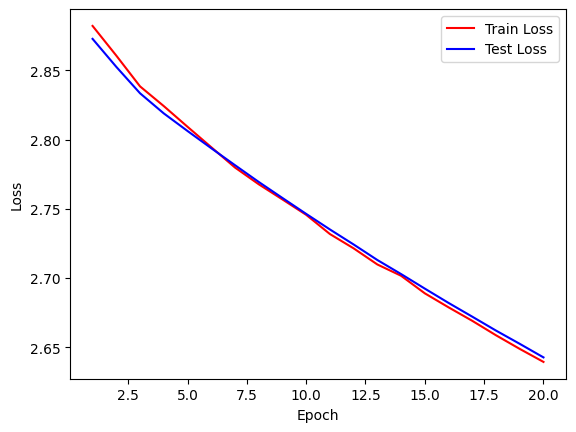

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='rnn'):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Invalid rnn_type. Use 'rnn', 'lstm', or 'gru'.")

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lengths = (x != 0).sum(dim=1)
        packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output[:, -1, :])
        return output

In [ ]:
input_size = len(all_chars)
hidden_size = 64
output_size = len(label_encoder.classes_)

In [ ]:
model = RNN(input_size, hidden_size, output_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
num_epochs = 20
train_losses = []
test_losses = []
list_time = []
list_memory = []
list_accuracy = []

In [ ]:
def train_rnn_type(rnn_type):
    start_time = time.time()

    def train_rnn():
        model = RNN(input_size, hidden_size, output_size, rnn_type)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_losses_per_type = []
        test_losses_per_type = []

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            total_samples = 0

            for names, targets in train_loader:
                optimizer.zero_grad()
                names = names.to(torch.long)
                targets = targets.to(torch.long)
                outputs = model(names)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * len(names)
                total_samples += len(names)

            avg_train_loss = total_loss / total_samples
            train_losses_per_type.append(avg_train_loss)

            avg_test_loss = evaluate_model(model, test_loader, criterion)
            test_losses_per_type.append(avg_test_loss)

            print(f'Epoch [{epoch + 1}/{num_epochs}], Type: {rnn_type}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        model.eval()
        all_preds = []
        all_targets = []

        for names, targets in test_loader:
            names = names.to(torch.long)
            targets = targets.to(torch.long)
            outputs = model(names)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

        accuracy = accuracy_score(all_targets, all_preds)
        list_accuracy.append(accuracy)

        end_time = time.time()
        elapsed_time = end_time - start_time
        list_time.append(elapsed_time)

        process = psutil.Process()
        list_memory.append(process.memory_info().rss / (1024 * 1024))

        train_losses.append(train_losses_per_type)
        test_losses.append(test_losses_per_type)

    train_rnn()


train_rnn_type('rnn')
train_rnn_type('lstm')
train_rnn_type('gru')

Epoch [1/20], Type: rnn, Train Loss: 2.7896, Test Loss: 2.7325
Epoch [2/20], Type: rnn, Train Loss: 2.6704, Test Loss: 2.6299
Epoch [3/20], Type: rnn, Train Loss: 2.5782, Test Loss: 2.5453
Epoch [4/20], Type: rnn, Train Loss: 2.4967, Test Loss: 2.4760
Epoch [5/20], Type: rnn, Train Loss: 2.4376, Test Loss: 2.4186
Epoch [6/20], Type: rnn, Train Loss: 2.3817, Test Loss: 2.3717
Epoch [7/20], Type: rnn, Train Loss: 2.3368, Test Loss: 2.3351
Epoch [8/20], Type: rnn, Train Loss: 2.2965, Test Loss: 2.3052
Epoch [9/20], Type: rnn, Train Loss: 2.2742, Test Loss: 2.2816
Epoch [10/20], Type: rnn, Train Loss: 2.2547, Test Loss: 2.2662
Epoch [11/20], Type: rnn, Train Loss: 2.2334, Test Loss: 2.2489
Epoch [12/20], Type: rnn, Train Loss: 2.2183, Test Loss: 2.2423
Epoch [13/20], Type: rnn, Train Loss: 2.2137, Test Loss: 2.2301
Epoch [14/20], Type: rnn, Train Loss: 2.2006, Test Loss: 2.2250
Epoch [15/20], Type: rnn, Train Loss: 2.1973, Test Loss: 2.2180
Epoch [16/20], Type: rnn, Train Loss: 2.1888, Tes

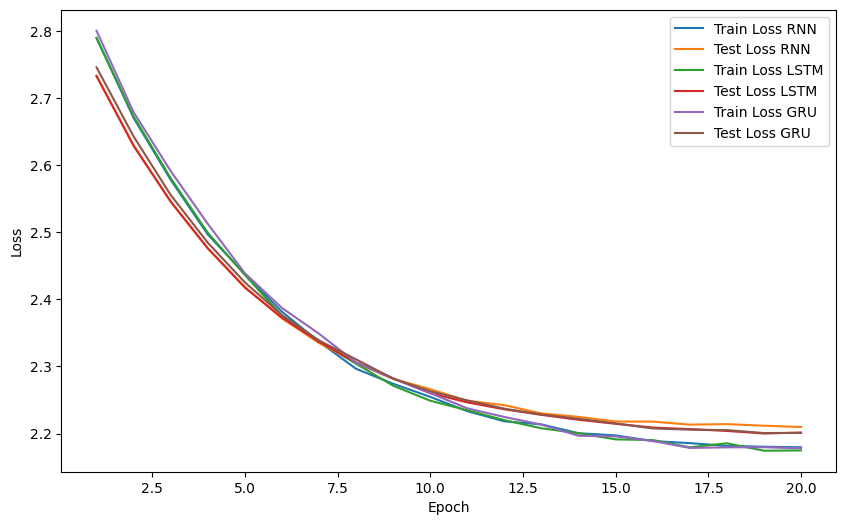

In [ ]:
plt.figure(figsize=(10, 6))

for i, rnn_type in enumerate(['RNN', 'LSTM', 'GRU']):
    plt.plot(range(1, num_epochs + 1), train_losses[i], label=f'Train Loss {rnn_type}')
    plt.plot(range(1, num_epochs + 1), test_losses[i], label=f'Test Loss {rnn_type}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
table = {'Name': ['RNN', 'LSTM', 'GRU'],
        'Время выполнения [с]': list_time,
        'Использование памяти [мб]': list_memory,
         'Точность': list_accuracy}
results = pd.DataFrame(table)
results

,Name,Время выполнения [с],Использование памяти [мб],Точность
0,RNN,67.046745,654.820312,0.282332
1,LSTM,83.002087,657.035156,0.283698
2,GRU,83.984046,657.292969,0.282787


1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [ ]:
embedding_dim = 50
embedding_path = '/content/drive/MyDrive/glove.6B.50d.txt'
embeddings_index = {}

In [ ]:
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
        embeddings_index[word] = coefs

embedding_matrix = torch.zeros(len(all_chars), embedding_dim)

for char, idx in char_to_index.items():
    if char in embeddings_index:
        embedding_matrix[idx] = embeddings_index[char]

In [ ]:
class RNNWithEmbeddings(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, rnn_type='rnn'):
        super(RNNWithEmbeddings, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        else:
            raise ValueError("Invalid rnn_type. Use 'rnn', 'lstm', or 'gru'.")

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lengths = (x != 0).sum(dim=1)
        packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output[:, -1, :])
        return output

In [ ]:
input_size = len(all_chars)
hidden_size = 64
output_size = len(label_encoder.classes_)

rnn_types = ['rnn', 'lstm', 'gru']
models = []

for rnn_type in rnn_types:
    model = RNNWithEmbeddings(embedding_matrix, hidden_size, output_size, rnn_type=rnn_type)
    models.append(model)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 20
train_losses = []
test_losses = []

for model, rnn_type in zip(models, rnn_types):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses_per_type = []
    test_losses_per_type = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0

        for names, targets in train_loader:
            optimizer.zero_grad()
            names = names.to(torch.long)
            targets = targets.to(torch.long)
            outputs = model(names)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(names)
            total_samples += len(names)

        avg_train_loss = total_loss / total_samples
        train_losses_per_type.append(avg_train_loss)

        avg_test_loss = evaluate_model(model, test_loader, criterion)
        test_losses_per_type.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Type: {rnn_type}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    train_losses.append(train_losses_per_type)
    test_losses.append(test_losses_per_type)

Epoch [1/20], Type: rnn, Train Loss: 2.7880, Test Loss: 2.7283
Epoch [2/20], Type: rnn, Train Loss: 2.6720, Test Loss: 2.6307
Epoch [3/20], Type: rnn, Train Loss: 2.5826, Test Loss: 2.5467
Epoch [4/20], Type: rnn, Train Loss: 2.5011, Test Loss: 2.4780
Epoch [5/20], Type: rnn, Train Loss: 2.4411, Test Loss: 2.4197
Epoch [6/20], Type: rnn, Train Loss: 2.3817, Test Loss: 2.3747
Epoch [7/20], Type: rnn, Train Loss: 2.3396, Test Loss: 2.3373
Epoch [8/20], Type: rnn, Train Loss: 2.3064, Test Loss: 2.3075
Epoch [9/20], Type: rnn, Train Loss: 2.2755, Test Loss: 2.2855
Epoch [10/20], Type: rnn, Train Loss: 2.2581, Test Loss: 2.2688
Epoch [11/20], Type: rnn, Train Loss: 2.2401, Test Loss: 2.2523
Epoch [12/20], Type: rnn, Train Loss: 2.2225, Test Loss: 2.2412
Epoch [13/20], Type: rnn, Train Loss: 2.2108, Test Loss: 2.2327
Epoch [14/20], Type: rnn, Train Loss: 2.2028, Test Loss: 2.2259
Epoch [15/20], Type: rnn, Train Loss: 2.1959, Test Loss: 2.2211
Epoch [16/20], Type: rnn, Train Loss: 2.1950, Tes

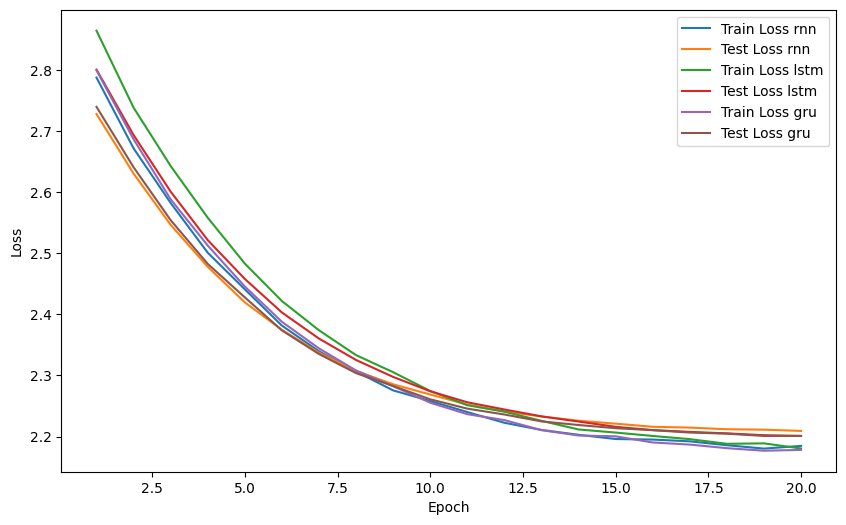

In [ ]:
plt.figure(figsize=(10, 6))

for i, rnn_type in enumerate(rnn_types):
    plt.plot(range(1, num_epochs + 1), train_losses[i], label=f'Train Loss {rnn_type}')
    plt.plot(range(1, num_epochs + 1), test_losses[i], label=f'Test Loss {rnn_type}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
from nltk import WordNetLemmatizer
from nltk import word_tokenize

In [ ]:
with open('/content/drive/MyDrive/positive_reviews.txt') as file:
    pos_reviews = file.readlines()
with open('/content/drive/MyDrive/negative_reviews.txt') as file:
    neg_reviews = file.readlines()

pos_reviews = pd.DataFrame(pos_reviews, columns=['review'])
pos_reviews['positive'] = 1
neg_reviews = pd.DataFrame(neg_reviews, columns=['review'])
neg_reviews['positive'] = 0

reviews = pd.concat([pos_reviews, neg_reviews])

In [ ]:
train_reviews, test_reviews = train_test_split(reviews, test_size=0.3)

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
class Vocab:
    def __init__(self, data: pd.Series):
        _word_bag = {'<UNK>'}
        for sent in data.review:
            sent = set(map(wnl.lemmatize, word_tokenize(sent)))
            _word_bag |= sent

        self.idx_to_token = dict(zip(range(1, len(_word_bag) + 1), _word_bag))

        self.token_to_idx = {v: u for u, v in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)
        self._word_bag = _word_bag

In [ ]:
vocab_review = Vocab(train_reviews)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, x: pd.Series, y: pd.Series, _vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, review: str):
        max_len = 64
        review = review.lower()
        output_tensor = []

        for l, word in enumerate(word_tokenize(review[:max_len]), 1):

            word = wnl.lemmatize(word)
            if word in self.vocab.token_to_idx.keys():
                output_tensor.append(self.vocab.token_to_idx[word])
            else:
                output_tensor.append(self.vocab.token_to_idx['<UNK>'])

        output_tensor = [0] * (max_len - len(output_tensor)) + output_tensor

        return output_tensor

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.LongTensor(self.vectorize(self.x.iloc[idx]))
        return x, torch.tensor(self.y.iloc[idx]).long()

In [ ]:
class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden.squeeze(0))
        out = self.fc(hidden)
        return out

In [ ]:
model = RNNModel(
    vocab_size=vocab_review.vocab_len + 1,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=2,
    n_layers=2,
    dropout=0.5
)

In [ ]:
review_train_ds = ReviewDataset(train_reviews.review, train_reviews.positive, vocab_review)
review_valid_ds = ReviewDataset(test_reviews.review, test_reviews.positive, vocab_review)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr = 0.0001)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

In [ ]:
train_loader = DataLoader(review_train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(review_valid_ds, batch_size=64, shuffle=True)

In [ ]:
for i in range(15):
    epoch_loss = 0
    epoch_loss_val = 0
    j, k = 1, 1

    model.train()

    for j, (batch_x, batch_y) in enumerate(train_loader, 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(test_loader, 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k


    if i % 1 == 0:

        print(f'Epoch [{i+1}/{15}], Train loss: {epoch_loss}, Train Loss: {epoch_loss_val:.4f}')

        right_answers = 0
        for batch_x, batch_y in DataLoader(review_valid_ds, batch_size=32):
            predictions = model(batch_x).argmax(dim=1)
            right_answers += (torch.eq(batch_y, predictions)).sum()

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

Epoch [1/15], Train loss: 0.6657300189010098, Train Loss: 0.6746
Epoch [2/15], Train loss: 0.6608847517233628, Train Loss: 0.6705
Epoch [3/15], Train loss: 0.659710963567098, Train Loss: 0.6694
Epoch [4/15], Train loss: 0.6580792033774221, Train Loss: 0.6684
Epoch [5/15], Train loss: 0.656694855954912, Train Loss: 0.6683
Epoch [6/15], Train loss: 0.6558336034799234, Train Loss: 0.6670
Epoch [7/15], Train loss: 0.6546779733437759, Train Loss: 0.6675
Epoch [8/15], Train loss: 0.6517313326525892, Train Loss: 0.6661
Epoch [9/15], Train loss: 0.651162976383144, Train Loss: 0.6657
Epoch [10/15], Train loss: 0.6506956652698354, Train Loss: 0.6651
Epoch [11/15], Train loss: 0.6488550957451519, Train Loss: 0.6648
Epoch [12/15], Train loss: 0.6474610628225864, Train Loss: 0.6651
Epoch [13/15], Train loss: 0.6462598835301195, Train Loss: 0.6636
Epoch [14/15], Train loss: 0.6453018988299574, Train Loss: 0.6632
Epoch [15/15], Train loss: 0.6423810032697824, Train Loss: 0.6638


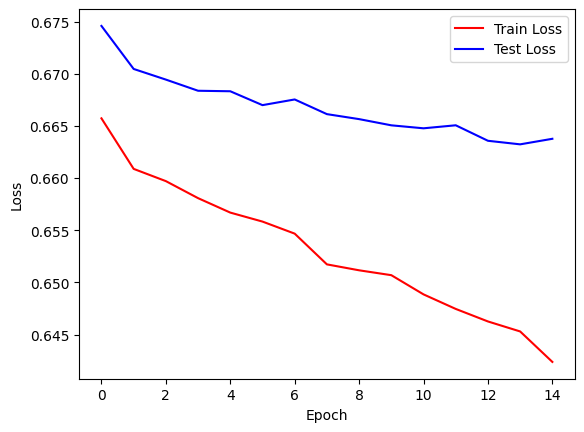

In [ ]:
plt.plot(loss_log, label='Train Loss', color='red')
plt.plot(loss_log_val, label='Test Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()